# Setup

## 1.1 Install Dependencies

In [4]:
#installed tensorflow, opencv and matplotlib

## Importing Dependencies

In [1]:
#standard dependencies
import cv2 #--> open cv 
import os #--> makes alot easier working with directories
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#tensorflow dependencies
#importing tensorflow functional api components
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten ,Dropout
#conv2d required to perform convolution
# maxpooling required to limit how much data we are passing to the next layer
import tensorflow as tf

2023-05-07 11:35:42.869737: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-07 11:35:42.989465: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-07 11:35:43.977954: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Set GPU Growth

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [4]:
#Avoid OOM erros by setting GPU Memory consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)

In [5]:
len(gpus)
# No GPU ON my laptop though :(

1

## Creating Folders

In [2]:
#Setting up paths for our 3 folders
POS_PATH = os.path.join('data','positive')
NEG_PATH = os.path.join('data','negative')
ANC_PATH = os.path.join('data','anchor')
TMP_PATH = os.path.join('data','temp')

In [68]:
ANC_PATH


'data/anchor'

In [4]:
#Making the folders/directories
# os.makedirs(POS_PATH)
# os.makedirs(NEG_PATH)
# os.makedirs(ANC_PATH) 
os.makedirs(TMP_PATH)

# Collect Data Images

## Setting up the negative data

In [24]:
#moving the lfw dataset to the negative folder made earlier
#basically cutting and pasting but using python for this work, instead of going to each folder and doing the hardwork
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        EX_PATH = os.path.join('lfw',directory,file)
        NEW_PATH = os.path.join(NEG_PATH,file)
        os.replace(EX_PATH,NEW_PATH)

        

In [25]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw',directory)):
        print(file)

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'lfw'

## Setting up the remaining data (Anchor and Positive)

In [7]:
# Import uuid library to generate unique image names
import uuid

In [71]:
uuid.uuid1()

UUID('a601cd2c-ea75-11ed-b27f-000c29b4f4a9')

In [84]:
 #--> gives us the whole path for the anchor images and the unique name
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data/anchor/a9be8f7c-ea75-11ed-b27f-000c29b4f4a9.jpg'

In [9]:
#establish a connection to the webcam
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]
    
    # Collect anchors
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname,frame)
        
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname,frame)
        
    if cv2.waitKey(1) & 0XFF == ord('t'):
        # Create the unique file path
        imgname = os.path.join(TMP_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname,frame)
    
    #show image back to screen
    cv2.imshow('Image Collection',frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break

# Release the webcam
cap.release()
#close the image show frame
cv2.destroyAllWindows()

In [60]:
cap.release()
#close the image show frame
cv2.destroyAllWindows()

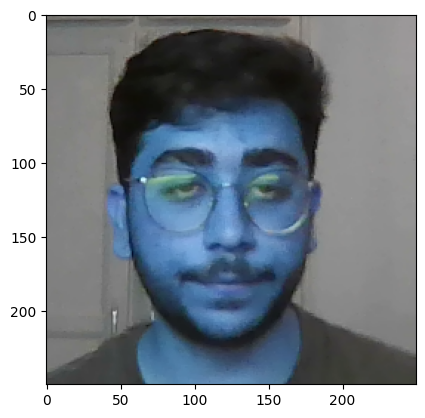

In [94]:
plt.imshow(frame)

In [36]:
#Frame is not 250x250 pixels like the one from the LFW Dataset
frame.shape

(480, 640, 3)

In [41]:
frame[:250,:250,:].shape
# Indexing can help with the pixel resizing

(250, 250, 3)

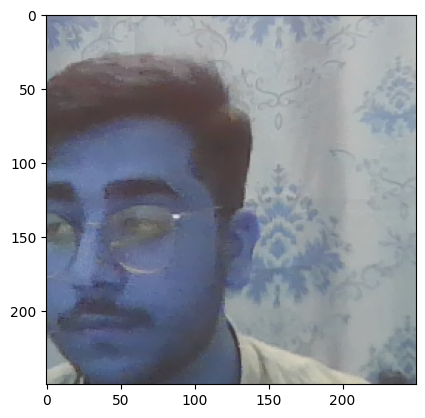

In [43]:
plt.imshow(frame[120:120+250,200:200+250,:]) #--> third colon represents the image channel

## Data Augmentation

In [20]:
def data_aug(img):
    data = []
    for i in range(9):
        img = tf.image.stateless_random_brightness(img,max_delta = 0.02, seed = (1,2))
        img = tf.image.stateless_random_contrast(img,lower = 0.6, upper = 1, seed =(1,3))
        img = tf.image.stateless_random_flip_left_right(img,seed= (np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_jpeg_quality(img,min_jpeg_quality = 90,max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        img = tf.image.stateless_random_saturation(img, lower = 0.9, upper = 1, seed =(np.random.randint(100),np.random.randint(100)))
        
        data.append(img)
    
    return data

In [9]:
# Testing the data augmentation function on 1 image
img_path = os.path.join(ANC_PATH, '7c0eefb8-df0f-11ed-be29-cb0869bce638.jpg')
img = cv2.imread(img_path)
augmented_images = data_aug(img)

for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())), image.numpy())

In [24]:
# applying data augmentation on both data sets inside the anchor and positive folders
for file_name in os.listdir(os.path.join(ANC_PATH)):
    img_path = os.path.join(ANC_PATH,file_name)
    img = cv2.imread(img_path)
    augmented_images = data_aug(img)
    
    for image in augmented_images:
        cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1())),image.numpy())

# Loading and Preprocessing Images

## Getting image directories

In [7]:
# creating a dataset of image file paths.
# API allows you to apply a wide range of transformations to it, such as shuffling, batching, mapping, and filtering.
anchor = tf.data.Dataset.list_files(ANC_PATH+'/*.jpg').take(4595)
positive = tf.data.Dataset.list_files(POS_PATH+'/*.jpg').take(4595)
negative = tf.data.Dataset.list_files(NEG_PATH+'/*.jpg').take(4595)

#getting 300 data image paths

2023-05-07 11:35:57.373678: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10182 MB memory:  -> device: 0, name: NVIDIA RTX A2000 12GB, pci bus id: 0000:03:00.0, compute capability: 8.6


In [87]:
ANC_PATH + '\*.jpg'

'data/anchor\\*.jpg'

In [26]:
ANC_PATH + '\*.jpg'

'data/anchor\\*.jpg'

In [10]:
dir_test = anchor.as_numpy_iterator()

In [17]:
dir_test.next()

b'data/anchor/30657b1c-e99a-11ed-8ee4-f4b3014801a1.jpg'

## Preprocessing

In [8]:
# Loading the image, resizing it, performing some scaling
def preprocess(file_path):
    # Reading in image from file path
    byte_img = tf.io.read_file(file_path)

    # Loading in Image
    img = tf.io.decode_jpeg(byte_img)
    
    # Prepocessing steps
    # Resizing the image to 100x100x3 as used in the paper
    img = tf.image.resize(img,(100,100))
    
    # Scaling the image to be between 0 and 1
    img = img / 255.0
    
    return img

In [19]:
img = preprocess('data/anchor/00a50a83-e977-11ed-a844-f4b3014801a1.jpg')

In [20]:
img = preprocess('data\\anchor\\b0567537-e977-11ed-8336-f4b3014801a1.jpg')

2023-05-05 17:09:20.265351: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at whole_file_read_ops.cc:114 : NOT_FOUND: data\anchor\b0567537-e977-11ed-8336-f4b3014801a1.jpg; No such file or directory


NotFoundError: {{function_node __wrapped__ReadFile_device_/job:localhost/replica:0/task:0/device:CPU:0}} data\anchor\b0567537-e977-11ed-8336-f4b3014801a1.jpg; No such file or directory [Op:ReadFile]

In [21]:
img

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7558824 , 0.7911765 , 0.77156866],
        [0.7519608 , 0.7872549 , 0.76960784],
        [0.7607843 , 0.7872549 , 0.77843136],
        ...,
        [0.79509807, 0.8186275 , 0.81078434],
        [0.7921569 , 0.8156863 , 0.80784315],
        [0.79289216, 0.81642157, 0.80857843]],

       [[0.75808823, 0.79044116, 0.77181375],
        [0.7561275 , 0.7862745 , 0.7703431 ],
        [0.7644608 , 0.7879902 , 0.7801471 ],
        ...,
        [0.79607844, 0.81764704, 0.81078434],
        [0.7948529 , 0.81642157, 0.8095588 ],
        [0.79313725, 0.8147059 , 0.80784315]],

       [[0.76004905, 0.78357846, 0.7678922 ],
        [0.7561275 , 0.7796569 , 0.76593137],
        [0.76004905, 0.78357846, 0.7757353 ],
        ...,
        [0.79901963, 0.8147059 , 0.81078434],
        [0.8       , 0.8156863 , 0.8117647 ],
        [0.7970588 , 0.8127451 , 0.8088235 ]],

       ...,

       [[0.6894608 , 0.70367646, 0.6997549 ],
        [0.68

In [22]:
print(img.numpy().max())
print(img.numpy().min())

#returning values between 0's and 1's

0.9169118
0.006862745


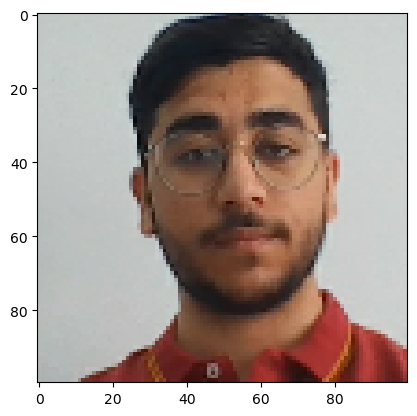

In [23]:
plt.imshow(img)

## Create labelled Dataset

In [57]:
# (anchor,positive) => 1,1,1,1,1
# (anchor,negative) => 0,0,0,0,0

In [59]:
tf.ones(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1

In [61]:
tf.zeros(len(anchor))

<tf.Tensor: shape=(300,), dtype=float32, numpy=
array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [9]:
positives = tf.data.Dataset.zip((anchor,positive,tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor,negative,tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [25]:
samples = data.as_numpy_iterator()

2023-05-05 17:09:39.560076: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [4595]
	 [[{{node Placeholder/_21}}]]
2023-05-05 17:09:39.560371: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [4595]
	 [[{{node Placeholder/_39}}]]


In [32]:
example = samples.next()

In [33]:
example

(b'data/anchor/3a921e07-e99a-11ed-ad6f-f4b3014801a1.jpg',
 b'data/positive/fbf6fddf-e999-11ed-81c2-f4b3014801a1.jpg',
 1.0)

## Build Train and Test Partition

In [10]:
# giving both the anchor and the postive image
def preprocess_twin(input_img,validation_img,label):
    return (preprocess(input_img),preprocess(validation_img),label)

In [35]:
res = preprocess_twin(*example)

In [102]:
res #--> returning 3 things

(<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
 array([[[0.7622549 , 0.69558823, 0.63284314],
         [0.7389706 , 0.6791667 , 0.6193628 ],
         [0.7080882 , 0.660049  , 0.60318625],
         ...,
         [0.7083333 , 0.72794116, 0.7122549 ],
         [0.76593137, 0.7884804 , 0.7727941 ],
         [0.7730392 , 0.79656863, 0.7828431 ]],
 
        [[0.7345588 , 0.67083335, 0.60808825],
         [0.7102941 , 0.6504902 , 0.5867647 ],
         [0.7588235 , 0.7223039 , 0.65318626],
         ...,
         [0.8002451 , 0.8183824 , 0.79387254],
         [0.73333335, 0.75735295, 0.73063725],
         [0.7921569 , 0.81960785, 0.7911765 ]],
 
        [[0.71617645, 0.6480392 , 0.5801471 ],
         [0.72083336, 0.6632353 , 0.59142154],
         [0.76348037, 0.7203431 , 0.64387256],
         ...,
         [0.8031863 , 0.81691176, 0.7894608 ],
         [0.79240197, 0.8120098 , 0.78455883],
         [0.76911765, 0.79656863, 0.7651961 ]],
 
        ...,
 
        [[0.6345588 , 0.64240193

In [89]:
res[0]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7764706 , 0.81960785, 0.827451  ],
        [0.7764706 , 0.81960785, 0.827451  ],
        [0.7794118 , 0.8254902 , 0.827451  ],
        ...,
        [0.8117647 , 0.85882354, 0.85882354],
        [0.8088235 , 0.85588235, 0.85588235],
        [0.8147059 , 0.8617647 , 0.8617647 ]],

       [[0.7764706 , 0.82058823, 0.8264706 ],
        [0.77254903, 0.81960785, 0.81960785],
        [0.7794118 , 0.8264706 , 0.8264706 ],
        ...,
        [0.8156863 , 0.8627451 , 0.8627451 ],
        [0.8127451 , 0.8598039 , 0.8598039 ],
        [0.8088235 , 0.85588235, 0.85588235]],

       [[0.7764706 , 0.8235294 , 0.8235294 ],
        [0.7757353 , 0.82279414, 0.82279414],
        [0.7764706 , 0.8235294 , 0.8235294 ],
        ...,
        [0.8127451 , 0.8598039 , 0.8598039 ],
        [0.8127451 , 0.8598039 , 0.8598039 ],
        [0.8156863 , 0.8627451 , 0.8627451 ]],

       ...,

       [[0.70392156, 0.74313724, 0.7509804 ],
        [0.70

In [105]:
res[1]

<tf.Tensor: shape=(100, 100, 3), dtype=float32, numpy=
array([[[0.7730392 , 0.69460785, 0.6514706 ],
        [0.73039216, 0.6617647 , 0.6137255 ],
        [0.7296569 , 0.6791667 , 0.6259804 ],
        ...,
        [0.7142157 , 0.725     , 0.70637256],
        [0.7801471 , 0.80269605, 0.7870098 ],
        [0.7801471 , 0.8036765 , 0.7879902 ]],

       [[0.74240196, 0.6727941 , 0.6159314 ],
        [0.72794116, 0.660049  , 0.60245097],
        [0.7654412 , 0.7144608 , 0.6507353 ],
        ...,
        [0.7877451 , 0.7977941 , 0.777451  ],
        [0.73308825, 0.7519608 , 0.73308825],
        [0.7862745 , 0.81078434, 0.7921569 ]],

       [[0.7002451 , 0.6335784 , 0.564951  ],
        [0.7392157 , 0.6727941 , 0.6041667 ],
        [0.7651961 , 0.7053922 , 0.6338235 ],
        ...,
        [0.81078434, 0.8208333 , 0.7968137 ],
        [0.78431374, 0.8009804 , 0.77843136],
        [0.76936275, 0.79093134, 0.76642156]],

       ...,

       [[0.6394608 , 0.64730394, 0.5982843 ],
        [0.64

In [36]:
res[2]

1.0

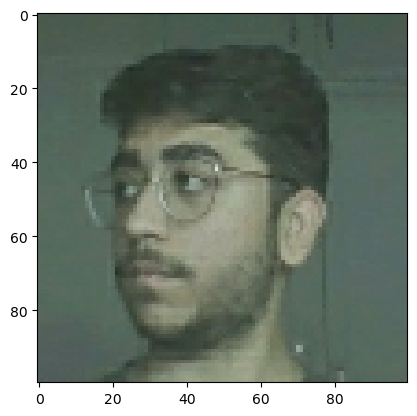

In [37]:
plt.imshow(res[1]) #--> positive image

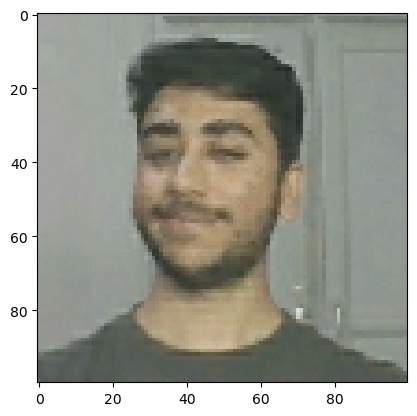

In [38]:
plt.imshow(res[0]) #--> anchor image

In [11]:
# Building a dataloader pipeline
# apllying the process done above on all the data instead of a just one tuple

data = data.map(preprocess_twin)
data = data.cache() #--> adding the preprocessed images to the cache
data = data.shuffle(buffer_size = 11000)

In [47]:
samples = data.as_numpy_iterator()

2023-05-05 17:13:09.738095: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype string and shape [4595]
	 [[{{node Placeholder/_9}}]]
2023-05-05 17:13:09.738614: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4595]
	 [[{{node Placeholder/_0}}]]


In [48]:
samp = samples.next()

In [49]:
len(samp)

3

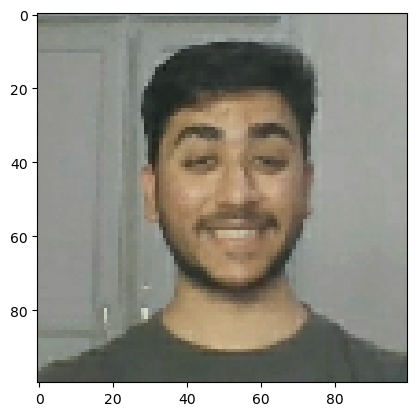

In [50]:
plt.imshow(samp[0])

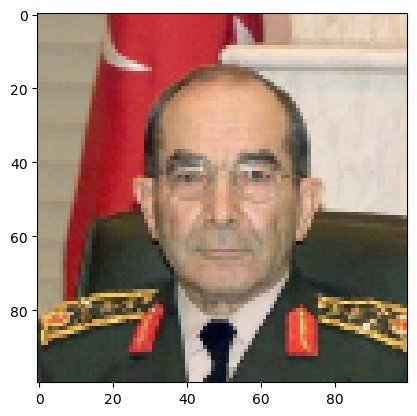

In [51]:
plt.imshow(samp[1])

In [53]:
samp[2]

0.0

In [12]:
# Training partition
train_data = data.take(round(len(data)*.8))
train_data = train_data.batch(16) #--> make batches to instead of 1 image we got 16 now
train_data = train_data.prefetch(8)

In [75]:
train_samples = train_data.as_numpy_iterator()

2023-05-05 23:25:54.517070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [4595]
	 [[{{node Placeholder/_0}}]]
2023-05-05 23:25:54.518001: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype string and shape [13233]
	 [[{{node Placeholder/_30}}]]


In [76]:
train_sample = train_samples.next()

In [77]:
len(train_sample[1])

16

In [13]:
# Testing partition
test_data = data.skip(round(len(data)*.8))
test_data = test_data.take(round(len(data)*0.2))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

# Model Engineering 

## Building Embedding Layer

In [10]:
inp = Input(shape = (100,100,3), name = 'input_image')
    

In [11]:
inp

<KerasTensor: shape=(None, 100, 100, 3) dtype=float32 (created by layer 'input_image')>

In [12]:
c1 = Conv2D(64,(10,10),activation='relu')(inp)

In [13]:
c1

<KerasTensor: shape=(None, 91, 91, 64) dtype=float32 (created by layer 'conv2d')>

In [14]:
m1 = MaxPooling2D(64,(2,2), padding= 'same')(c1)

In [15]:
m1

<KerasTensor: shape=(None, 46, 46, 64) dtype=float32 (created by layer 'max_pooling2d')>

In [16]:
c2 = Conv2D(128,(7,7),activation= 'relu')(m1)
m2 = MaxPooling2D(64,(2,2), padding= 'same')(c2)

In [17]:
c2

<KerasTensor: shape=(None, 40, 40, 128) dtype=float32 (created by layer 'conv2d_1')>

In [18]:
m2

<KerasTensor: shape=(None, 20, 20, 128) dtype=float32 (created by layer 'max_pooling2d_1')>

In [19]:
c3 = Conv2D(128,(4,4),activation= 'relu')(m2)
m3 = MaxPooling2D(64,(2,2), padding= 'same')(c3)

In [20]:
c3

<KerasTensor: shape=(None, 17, 17, 128) dtype=float32 (created by layer 'conv2d_2')>

In [21]:
m3

<KerasTensor: shape=(None, 9, 9, 128) dtype=float32 (created by layer 'max_pooling2d_2')>

In [23]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
#Flattening 3D into 1
f1 = Flatten()(c4) 
d1 = Dense(4096,activation= 'sigmoid')(f1)

In [24]:
c4

<KerasTensor: shape=(None, 6, 6, 256) dtype=float32 (created by layer 'conv2d_4')>

In [25]:
f1

<KerasTensor: shape=(None, 9216) dtype=float32 (created by layer 'flatten_1')>

In [26]:
d1

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'dense_1')>

In [27]:
mod = Model(inputs=[inp] ,outputs =[d1] ,name ='embedding')

In [29]:
mod.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 91, 91, 64)        19264     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 20, 20, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 17, 17, 128)       26

In [15]:
# def make_embedding():
#     # input layer
#     inp = Input(shape=(100, 100, 3), name='input_image')

#     # --> First Block
#     # convolution + relu layer
#     c1 = Conv2D(64, (10, 10), activation='relu')(inp)
#     # dropout layer
#     d1 = Dropout(0.25)(c1)
#     # maxpooling layer
#     m1 = MaxPooling2D(64, (2, 2), padding='same')(d1)

#     # --> Second Block
#     c2 = Conv2D(128, (7, 7), activation='relu')(m1)
#     # dropout layer
#     d2 = Dropout(0.25)(c2)
#     m2 = MaxPooling2D(64, (2, 2), padding='same')(d2)

#     # --> Third Block
#     c3 = Conv2D(128, (4, 4), activation='relu')(m2)
#     m3 = MaxPooling2D(64, (2, 2), padding='same')(c3)

#     # --> Final Embedding Block
#     c4 = Conv2D(256, (4, 4), activation='relu')(m3)
#     # Flattening 3D into 1
#     f1 = Flatten()(c4)
#     d3 = Dense(4096, activation='sigmoid')(f1)
#     # dropout layer
#     d4 = Dropout(0.5)(d3)

#     return Model(inputs=[inp], outputs=[d4], name='embedding')


In [14]:
def make_embedding():
#     input layer
    inp = Input(shape = (100,100,3), name = 'input_image')
    
    
    #--> First Block
    #convolution + relu layer
    c1 = Conv2D(64,(10,10),activation='relu')(inp)
    #maxpooling layer
    m1 = MaxPooling2D(64,(2,2), padding= 'same')(c1)
    
    #--> Second Block
    c2 = Conv2D(128,(7,7),activation= 'relu')(m1)
    m2 = MaxPooling2D(64,(2,2), padding= 'same')(c2)
    
    #--> Third Block
    c3 = Conv2D(128,(4,4),activation= 'relu')(m2)
    m3 = MaxPooling2D(64,(2,2), padding= 'same')(c3)
    
    #--> Final Embedding Block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    #Flattening 3D into 1
    f1 = Flatten()(c4) 
    d1 = Dense(4096,activation= 'sigmoid')(f1)
    
    return Model(inputs=[inp] ,outputs =[d1] ,name ='embedding')

In [15]:
embedding = make_embedding()

In [19]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_image (InputLayer)    [(None, 100, 100, 3)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 91, 91, 64)        19264     
                                                                 
 dropout (Dropout)           (None, 91, 91, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 46, 46, 64)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 40, 40, 128)       401536    
                                                                 
 dropout_1 (Dropout)         (None, 40, 40, 128)       0         
                                                         

##  Building Distance Layer

In [16]:
# Siamese L1 Distance Class
class L1Dist(Layer):
    def __init__(self, **kwargs):
        super().__init__()
    
    # similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [36]:
l1 = L1Dist()

In [39]:
l1

In [41]:
# l1(anchor_embedding,validation_embedding) # --> combining this with a fully connected layer to get final output

## Making the Siamese Model

In [44]:
input_image = Input(name = 'input_img',shape = (100,100,3))
validation_image = Input(name = 'validation_img',shape = (100,100,3))

In [45]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [46]:
inp_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [47]:
val_embedding

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'embedding')>

In [48]:
siamese_layer = L1Dist()

In [50]:
distances = siamese_layer(inp_embedding,val_embedding)

In [51]:
classifier = Dense(1,activation= 'sigmoid')(distances)

In [52]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_5')>

In [53]:
siamese_network = Model(inputs = [input_image,validation_image], outputs = classifier, name = 'SiameseNetwork')

In [54]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

In [17]:
def make_siamese_model():
    # Anchor image input in the network
    input_image = Input(name = 'input_img',shape = (100,100,3))
    
    # Validation Image in the netwrok
    validation_image = Input(name = 'validation_img',shape = (100,100,3))
    
    # Combining siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification Layer
    classifier = Dense(1,activation= 'sigmoid')(distances)
    
    return Model(inputs = [input_image,validation_image], outputs = classifier, name = 'SiameseNetwork')

In [18]:
siamese_model = make_siamese_model()

In [110]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Training

## Setting up Loss and Optimizer

In [23]:
# #using the triplet loss function for the siamese model
# def triplet_loss(y_true, y_pred, alpha = 0.2):
#     anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    
#     pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
#     neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
#     basic_loss = pos_dist - neg_dist + alpha
#     loss = tf.reduce_sum(tf.maximum(basic_loss, 0.0))
    
#     return loss


In [29]:
# triplet_loss_fn = triplet_loss


In [19]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [20]:
#choosing adam optimizer
opt = tf.keras.optimizers.Adam(1e-4) #0.0001
# Choosing SGD optimizer
# opt = tf.keras.optimizers.SGD(learning_rate=0.001 ,momentum=0.9)


In [43]:
# from tensorflow.keras import backend as K

# def contrastive_loss(y_true, y_pred):
#     margin = 1
#     square_pred = K.square(y_pred)
#     margin_square = K.square(K.maximum(margin - y_pred, 0))
#     return K.mean(y_true * square_pred + (1 - y_true) * margin_square)

# contrastive_loss = contrastive_loss

## Establishing Checkpoints

In [21]:
checkpoint_dir = './training_checkpoints'

In [22]:
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt = opt, siamese_model = siamese_model)

## Building Train Step Function

In [58]:
test_batch = train_data.as_numpy_iterator()

In [59]:
batch_1 = test_batch.next()

In [60]:
batch_1[2]

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [61]:
X = batch_1[:2]

In [62]:
np.array(X).shape

(2, 16, 100, 100, 3)

In [63]:
y = batch_1[2]

In [64]:
y

array([0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.],
      dtype=float32)

In [23]:
# wrapping the function inside a decorator
@tf.function
def train_step(batch):
    
    #Record all of our operations here
    with tf.GradientTape() as tape:
        #Get anchor and positive/negative image
        x = batch[:2]
        #Get label
        y = batch[2]
        
        # forward pass  
        yhat = siamese_model(x, training = True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat) #--> passing the true and prediction values to the loss function
    print(loss)
    
    # Calculate gradients
    grad = tape.gradient(loss,siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
    
    return loss

In [24]:
# Define a function for validation
@tf.function
def validation_step(batch):
    # Get anchor and positive/negative image
    x = batch[:2]
    # Get label
    y = batch[2]

    # forward pass
    yhat = siamese_model(x, training=False)
    # Calculate loss
    loss = binary_cross_loss(y, yhat)  # --> passing the true and prediction values to the loss function

    return loss


## Building Training Loop

In [25]:
# Importing metric calculations
from tensorflow.keras.metrics import Precision,Recall

In [57]:
!pip install sklearn

/bin/bash: /home/ubuntu/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post4-py3-none-any.whl size=2950 sha256=d38b20836ea154c6f5fe17088c2b99b5e8d0568161a69943dea1b012b5f4df0b
  Stored in directory: /home/ubuntu/.cache/pip/wheels/de/6a/05/7cad3fe50c04cfcba9f13bf25766f6fa85764e4f76f5c4fd98
Successfully built sklearn


In [79]:
# import numpy as np
# from sklearn.metrics import confusion_matrix

# # Define a function for training
# def train(train_data, test_data, EPOCHS):
#     # Loop through epochs
#     for epoch in range(1, EPOCHS + 1):
#         print('\nEpoch {}/{}'.format(epoch, EPOCHS))
#         # Create a progress bar
#         progbar = tf.keras.utils.Progbar(len(train_data))

#         # Create metric objects for loss and performance
#         train_loss = tf.keras.metrics.Mean(name='train_loss')
#         train_recall = Recall(name='train_recall')
#         train_precision = Precision(name='train_precision')
#         val_loss = tf.keras.metrics.Mean(name='val_loss')
#         val_recall = Recall(name='val_recall')
#         val_precision = Precision(name='val_precision')

#         # Loop through training data
#         for idx, batch in enumerate(train_data):
#             # Run train step here
#             loss = train_step(batch)
#             yhat = siamese_model.predict(batch[:2])
#             train_loss.update_state(loss)
#             train_recall.update_state(batch[2], yhat)
#             train_precision.update_state(batch[2], yhat)
#             progbar.update(idx + 1)

#         # Evaluate the model on the validation data
#         y_true = []
#         y_pred = []
#         for idx, batch in enumerate(test_data):
#             # Run validation step here
#             loss = validation_step(batch)
#             yhat = siamese_model.predict(batch[:2])
#             val_loss.update_state(loss)
#             val_recall.update_state(batch[2], yhat)
#             val_precision.update_state(batch[2], yhat)
#             y_true.extend(batch[2].numpy())
#             y_pred.extend(np.round(yhat).flatten())

#         # Print metrics
#         template = 'Train Loss: {}, Train Recall: {}, Train Precision: {}, Val Loss: {}, Val Recall: {}, Val Precision: {}'
#         print(template.format(train_loss.result(), train_recall.result(), train_precision.result(),
#                               val_loss.result(), val_recall.result(), val_precision.result()))

#         # Compute and print confusion matrix
#         cm = confusion_matrix(y_true, y_pred)
#         print('Confusion matrix:')
#         print(cm)

#         # Save checkpoints
#         if epoch % 5 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)


In [26]:
# Define a function for training
def train(train_data, test_data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS + 1):
        print('\nEpoch {}/{}'.format(epoch, EPOCHS))
        # Create a progress bar
        progbar = tf.keras.utils.Progbar(len(train_data))

        # Create metric objects for loss and performance
        train_loss = tf.keras.metrics.Mean(name='train_loss')
        train_recall = Recall(name='train_recall')
        train_precision = Precision(name='train_precision')
        val_loss = tf.keras.metrics.Mean(name='val_loss')
        val_recall = Recall(name='val_recall')
        val_precision = Precision(name='val_precision')

        # Loop through training data
        for idx, batch in enumerate(train_data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            train_loss.update_state(loss)
            train_recall.update_state(batch[2], yhat)
            train_precision.update_state(batch[2], yhat)
            progbar.update(idx + 1)

        # Evaluate the model on the validation data
        for idx, batch in enumerate(test_data):
            # Run validation step here
            loss = validation_step(batch)
            yhat = siamese_model.predict(batch[:2])
            val_loss.update_state(loss)
            val_recall.update_state(batch[2], yhat)
            val_precision.update_state(batch[2], yhat)

        # Print metrics
        template = 'Train Loss: {}, Train Recall: {}, Train Precision: {}, Val Loss: {}, Val Recall: {}, Val Precision: {}'
        print(template.format(train_loss.result(), train_recall.result(), train_precision.result(),
                              val_loss.result(), val_recall.result(), val_precision.result()))

        # Save checkpoints
        if epoch % 10 == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)


In [132]:
# def train(data,EPOCHS):
#     # Loop thorugh epochs
#     for epoch in range(1, EPOCHS + 1):
#         print('\n Epoch {}/{}'.format(epoch,EPOCHS))
#         progbar = tf.keras.utils.Progbar(len(data))
        
#         # Creating a metric object
#         # loss and performance metrics
#         r = Recall()
#         p = Precision()
        
#         #loop thoigh each batch
#         for idx, batch in enumerate(data):
#             # Run train step here
#             loss = train_step(batch)
#             yhat = siamese_model.predict(batch[:2])
#             r.update_state(batch[2],yhat)
#             p.update_state(batch[2],yhat)    
#             progbar.update(idx + 1)
            
#         print(loss.numpy(), r.result().numpy(), p.result().numpy())
            
#         # Save checkpoints
#         if epoch % 5 == 0:
#             checkpoint.save(file_prefix=checkpoint_prefix)

## Training the Model

In [28]:
EPOCHS = 30

In [29]:
train(train_data,test_data,EPOCHS)


Epoch 1/30


2023-05-07 11:37:10.194984: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [4595]
	 [[{{node Placeholder/_21}}]]
2023-05-07 11:37:10.195874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_21' with dtype string and shape [4595]
	 [[{{node Placeholder/_21}}]]


Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)
Tensor("binary_crossentropy/weighted_loss/value:0", shape=(), dtype=float32)


2023-05-07 11:37:13.097131: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-07 11:37:13.635773: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-07 11:37:13.972900: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-05-07 11:37:13.979304: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb6a8018ed0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-07 11:37:13.979324: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA RTX A2000 12GB, Compute Capability 8.6
2023-05-07 11:37:13.992720: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-07 11:37:14.033635: I ./tensorflow/compiler/jit/device_compiler

1/1 [==============================] - 0s 130ms/step


460/460 [==============================] - 125s 261ms/step


2023-05-07 11:39:15.260222: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_39' with dtype float and shape [4595]
	 [[{{node Placeholder/_39}}]]
2023-05-07 11:39:15.260692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_30' with dtype string and shape [4595]
	 [[{{node Placeholder/_30}}]]


1/1 [==============================] - 0s 17ms/step
Train Loss: 0.4769386649131775, Train Recall: 0.6242210865020752, Train Precision: 0.9110320210456848, Val Loss: 0.24649417400360107, Val Recall: 0.961240291595459, Val Precision: 0.9741863012313843

Epoch 2/30
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 58ms/step


1/1 [==============================] - 0s 50ms/step
Train Loss: 0.1756741851568222, Train Recall: 0.9694759845733643, Train Precision: 0.9750068187713623, Val Loss: 0.13150480389595032, Val Recall: 0.9676026105880737, Val Precision: 0.9792349934577942

Epoch 3/30
1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 57ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.09950849413871765, Train Recall: 0.987459123134613, Train Precision: 0.986652135848999, Val Loss: 0.0570003017783165, Val Recall: 0.9955898523330688, Val Precision: 0.9868852496147156

Epoch 4/30
1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 49ms/step
Train Loss: 0.057161059230566025, Train Recall: 0.9964568018913269, Train Precision: 0.9921302795410156, Val Loss: 0.05577040836215019, Val Recall: 0.9901639223098755, Val Precision: 0.9901639223098755

Epoch 5/30


1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 50ms/step
Train Loss: 0.046101976186037064, Train Recall: 0.9967051148414612, Train Precision: 0.9931600689888, Val Loss: 0.028738653287291527, Val Recall: 0.9977728128433228, Val Precision: 0.996662974357605

Epoch 6/30
1/1 [==============================] - 0s 140ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 43ms/step
Train Loss: 0.03278790041804314, Train Recall: 0.9983757734298706, Train Precision: 0.9951429963111877, Val Loss: 0.039528556168079376, Val Recall: 0.9854260087013245, Val Precision: 0.9965986609458923

Epoch 7/30
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.03278982266783714, Train Recall: 0.998643159866333, Train Precision: 0.9972899556159973, Val Loss: 0.03222734108567238, Val Recall: 0.9967776536941528, Val Precision: 0.9946409463882446

Epoch 8/30
1/1 [==============================] - 0s 121ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.019993554800748825, Train Recall: 0.9994584321975708, Train Precision: 0.9986472129821777, Val Loss: 0.01247486099600792, Val Recall: 1.0, Val Precision: 0.9989200830459595

Epoch 9/30


1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 49ms/step
Train Loss: 0.02106310985982418, Train Recall: 0.999186098575592, Train Precision: 0.998644232749939, Val Loss: 0.012894492596387863, Val Recall: 1.0, Val Precision: 0.998908281326294

Epoch 10/30
1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 137ms/step


1/1 [==============================] - 0s 45ms/step
Train Loss: 0.015007476322352886, Train Recall: 0.999728262424469, Train Precision: 0.999728262424469, Val Loss: 0.014591993764042854, Val Recall: 0.998910665512085, Val Precision: 0.9967391490936279

Epoch 11/30
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.019240006804466248, Train Recall: 0.9997255802154541, Train Precision: 0.998903214931488, Val Loss: 0.01332034356892109, Val Recall: 1.0, Val Precision: 0.9978471398353577

Epoch 12/30
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 138ms/step


1/1 [==============================] - 0s 47ms/step
Train Loss: 0.01036714669317007, Train Recall: 0.999729335308075, Train Precision: 0.999729335308075, Val Loss: 0.00643879221752286, Val Recall: 1.0, Val Precision: 1.0

Epoch 13/30
1/1 [==============================] - 0s 145ms/step


1/1 [==============================] - 0s 52ms/step


1/1 [==============================] - 0s 45ms/step
Train Loss: 0.006275653839111328, Train Recall: 1.0, Train Precision: 0.9997279644012451, Val Loss: 0.006851028650999069, Val Recall: 1.0, Val Precision: 1.0

Epoch 14/30
1/1 [==============================] - 0s 131ms/step


1/1 [==============================] - 0s 54ms/step


1/1 [==============================] - 0s 44ms/step
Train Loss: 0.005286022555083036, Train Recall: 1.0, Train Precision: 1.0, Val Loss: 0.0033304193057119846, Val Recall: 1.0, Val Precision: 1.0

Epoch 15/30
1/1 [==============================] - 0s 132ms/step


1/1 [==============================] - 0s 59ms/step


1/1 [==============================] - 0s 44ms/step
Train Loss: 0.00532981613650918, Train Recall: 1.0, Train Precision: 0.9997280240058899, Val Loss: 0.013697111047804356, Val Recall: 0.997770369052887, Val Precision: 0.997770369052887

Epoch 16/30
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 44ms/step
Train Loss: 0.008651538752019405, Train Recall: 1.0, Train Precision: 0.9994568228721619, Val Loss: 0.005708193872123957, Val Recall: 1.0, Val Precision: 1.0

Epoch 17/30
1/1 [==============================] - 0s 139ms/step


1/1 [==============================] - 0s 120ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.005230524577200413, Train Recall: 1.0, Train Precision: 1.0, Val Loss: 0.0036552436649799347, Val Recall: 1.0, Val Precision: 1.0

Epoch 18/30
1/1 [==============================] - 0s 136ms/step


1/1 [==============================] - 0s 134ms/step


1/1 [==============================] - 0s 48ms/step
Train Loss: 0.0030376275535672903, Train Recall: 1.0, Train Precision: 1.0, Val Loss: 0.0022123183589428663, Val Recall: 1.0, Val Precision: 1.0

Epoch 19/30
1/1 [==============================] - 0s 142ms/step


1/1 [==============================] - 0s 94ms/step


1/1 [==============================] - 0s 42ms/step
Train Loss: 0.00277257920242846, Train Recall: 1.0, Train Precision: 1.0, Val Loss: 0.0024335526395589113, Val Recall: 1.0, Val Precision: 1.0

Epoch 20/30
1/1 [==============================] - 0s 145ms/step


KeyboardInterrupt: 

# Evaluating Model

In [33]:
# Importing metric calculation
# precision recall curve
# loss
from tensorflow.keras.metrics import Precision, Recall

## Making predictions 

In [31]:
#Getting a batch of test data
# unpacking the values inside the test_data

test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [32]:
# Making predictions
y_hat = siamese_model.predict([test_input,test_val])
y_hat

1/1 [==============================] - 0s 25ms/step


array([[3.0544852e-06],
       [9.9999988e-01],
       [1.3858950e-03],
       [9.9998641e-01],
       [1.0000000e+00],
       [9.9948752e-01],
       [6.5789063e-05],
       [9.9999881e-01],
       [9.9996722e-01],
       [1.9177120e-05],
       [5.1474458e-06],
       [6.8938800e-07],
       [6.2317440e-07],
       [9.4798106e-06],
       [9.9999988e-01],
       [2.2001233e-05]], dtype=float32)

In [34]:
# Post processing the results
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0]

In [35]:
y_true

array([0., 1., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 0., 1., 0.],
      dtype=float32)

## Calculating Metrics

In [36]:
# Creating a metric object
m = Recall()

# Calculating the recall value
m.update_state(y_true,y_hat)

# Returning recall result
m.result().numpy()

1.0

In [37]:
# Creating a metric object
n = Precision()

# Calculating the precision value
n.update_state(y_true,y_hat)

# Returning precison result
n.result().numpy()

1.0

In [38]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input,test_val])
    r.update_state(y_true,yhat)
    p.update_state(y_true,yhat)
    
print(r.result().numpy(),p.result().numpy())

1/1 [==============================] - 0s 15ms/step
1.0 1.0


## Visualizing results

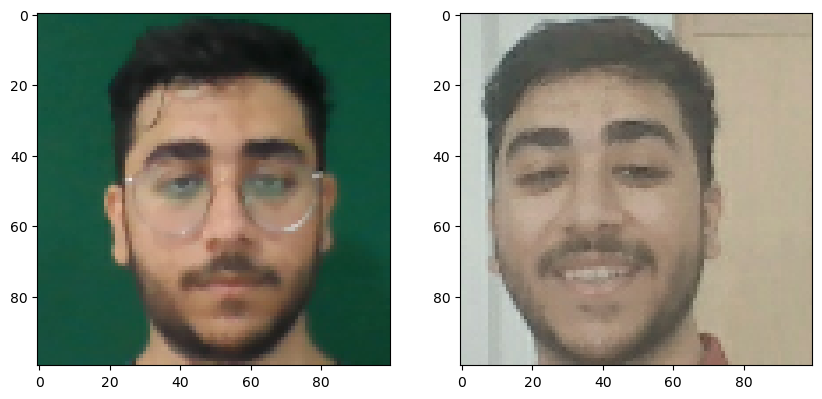

In [103]:
# Setting plot size
plt.figure(figsize=(10,8))

plt.subplot(1,2,1)
plt.imshow(test_input[4])

plt.subplot(1,2,2)
plt.imshow(test_val[4])
plt.show()

# Saving the model

In [30]:
# Saving weights
siamese_model.save('siamesemodelv14FinalSGD.h5')

In [197]:
# Reloading model
model = tf.keras.models.load_model('siamesemodelv7.h5',
                                   custom_objects={'L1Dist': L1Dist, 'BinaryCrossentropy': tf.losses.BinaryCrossentropy})

In [201]:
# make predictions with the reloaded model
model.predict([test_input,test_val])

1/1 [==============================] - 0s 342ms/step


array([[1.0000000e+00],
       [1.0000000e+00],
       [4.8458975e-07],
       [2.0221667e-09],
       [8.4724483e-08],
       [9.9902475e-01],
       [9.9999934e-01],
       [2.8803800e-06],
       [9.9997854e-01],
       [9.9984497e-01],
       [9.9999940e-01],
       [9.9999982e-01],
       [3.5375365e-06],
       [8.6035079e-06],
       [9.9994349e-01],
       [9.9998629e-01]], dtype=float32)

In [202]:
# Viewing model summary
model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_img (InputLayer)         [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 validation_img (InputLayer)    [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 embedding (Functional)         (None, 4096)         38960448    ['input_img[0][0]',              
                                                                  'validation_img[0][

# Run Time Test

## Verfication function

In [203]:
def verify(model,detection_threshold, verification_threshold):
    # Building results array
    results = []
    for image in os.listdir(os.path.join('application_data','verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image','input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Making predictions
        result = model.predict(list(np.expand_dims([input_img,validation_img],axis = 1)))
        results.append(result)
        
    # Detection Threshold: Metric above which a prediction is considered positive
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verfication Threshold: Proportion of positive predictions / total positive sampels
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images')))
    verified = verification > verification_threshold
    
    return results , verified

## OpenCV Real TIme Verification

In [204]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret,frame = cap.read()
    
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250,:]
    
    cv2.imshow('Verfication',frame)
    
    # Verification Trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):
        # save input image to application_data/input_img folder
        cv2.imwrite(os.path.join('application_data','input_image', 'input_image.jpg'), frame)
        # Run verification
        results,verified = verify(model,0.7,0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

[ WARN:0@21769.069] global cap_v4l.cpp:982 open VIDEOIO(V4L2:/dev/video0): can't open camera by index
[ERROR:0@21769.070] global obsensor_uvc_stream_channel.cpp:156 getStreamChannelGroup Camera index out of range


# Reference

#The code used for the project was referenced from the following GitHub repository:
# https://github.com/nicknochnack/FaceRecognition.
# However, several modifications were made to enhance the model's
# efficiency, such as changes in dataset selection, data augmentation techniques, model architecture,
# training process, and hyperparameter tuning. These changes helped to improve the accuracy of the model 
# and make it suitable for the specific use case.

In [ ]:
print('hello')